In [15]:
# First let's import
# Let's do our imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pandas_profiling
import seaborn as sns; sns.set()
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.player import AbstractPlayer
from sportsreference.nba.teams import Teams
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [54]:
rawpast = pd.read_csv("https://raw.githubusercontent.com/Build-Week-NBA-Longevity-Predictor/Data-Science/master/1976_to_2015_Draftees_edit2.csv")

pd.set_option('display.max_columns', 90)
rawpast.head(10)


,Unnamed: 0,Player,All_NBA,All.Star,Draft_Yr,Pk,Team,College,Yrs,Games,Minutes.Played,PTS,TRB,AST,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,Win.Share,WS_per_game,BPM,VORP,Executive,Tenure,Exec_ID,Exec_draft_exp,attend_college,first_year,second_year,third_year,fourth_year,fifth_year
0,1,Robert Parish,2,9,1976,8,GSW,Centenary College of Louisiana,21,1611,45704,23334,14715,2180,0.537,0.0,0.721,28.4,14.5,9.1,1.4,147.0,0.154,1.6,41.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
1,2,Sonny Parker,0,0,1976,17,GSW,Texas A&M University,6,452,10916,4471,1841,954,0.501,0.0,0.755,24.2,9.9,4.1,2.1,26.9,0.118,2.2,11.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
2,3,Marshall Rogers,0,0,1976,34,GSW,University of Texas-Pan American,1,26,176,100,11,10,0.371,0.0,0.933,6.8,3.8,0.4,0.4,-0.2,-0.043,-9.9,-0.4,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
3,4,Jeff Fosnes,0,0,1976,68,GSW,Vanderbilt University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
4,5,Carl Bird,0,0,1976,86,GSW,University of California,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
5,6,Duane Barnett,0,0,1976,91,GSW,Stanford University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
6,7,Gene Cunningham,0,0,1976,104,GSW,Norfolk State University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
7,8,Jesse Campbell,0,0,1976,122,GSW,Mercyhurst College,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
8,9,Stan Boskovich,0,0,1976,140,GSW,West Virginia University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
9,10,Howard Smith,0,0,1976,157,GSW,University of San Francisco,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0


In [10]:
profile = rawpast.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="rawpastprofile.html")

In [3]:
# Now we're going to get rid of the observations with 0 years, as those rows are inherently useless to us
rawpast = rawpast[rawpast['Yrs'] != 0]
rawpast.head(10)

,Unnamed: 0,Player,All_NBA,All.Star,Draft_Yr,Pk,Team,College,Yrs,Games,Minutes.Played,PTS,TRB,AST,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,Win.Share,WS_per_game,BPM,VORP,Executive,Tenure,Exec_ID,Exec_draft_exp,attend_college,first_year,second_year,third_year,fourth_year,fifth_year
0,1,Robert Parish,2,9,1976,8,GSW,Centenary College of Louisiana,21,1611,45704,23334,14715,2180,0.537,0.000,0.721,28.4,14.5,9.1,1.4,147.0,0.154,1.6,41.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
1,2,Sonny Parker,0,0,1976,17,GSW,Texas A&M University,6,452,10916,4471,1841,954,0.501,0.000,0.755,24.2,9.9,4.1,2.1,26.9,0.118,2.2,11.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
2,3,Marshall Rogers,0,0,1976,34,GSW,University of Texas-Pan American,1,26,176,100,11,10,0.371,0.000,0.933,6.8,3.8,0.4,0.4,-0.2,-0.043,-9.9,-0.4,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
11,12,Rickey Green,0,0,1977,16,GSW,University of Michigan,14,946,23271,8870,1819,5221,0.469,0.207,0.807,24.6,9.4,1.9,5.5,47.2,0.097,-1.0,5.8,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
12,13,Wesley Cox,0,0,1977,18,GSW,University of Louisville,2,74,813,342,206,23,0.412,0.000,0.510,11.0,4.6,2.8,0.3,0.1,0.007,-6.9,-1.0,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
14,15,Marlon Redmond,0,0,1977,60,GSW,University of San Francisco,2,77,1057,499,161,77,0.423,0.000,0.655,13.7,6.5,2.1,1.0,0.6,0.026,-3.8,-0.5,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
17,18,Ray Epps,0,0,1977,104,GSW,Norfolk State University,1,13,72,26,5,2,0.435,0.000,0.750,5.5,2.0,0.4,0.2,0.1,0.057,-6.9,-0.1,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
20,21,Ricky Marsh,0,0,1977,165,GSW,Manhattan College,1,60,851,269,75,90,0.426,0.000,0.697,14.2,4.5,1.3,1.5,0.5,0.028,-4.3,-0.5,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
21,22,Purvis Short,0,0,1978,5,GSW,Jackson State University,12,842,24549,14607,3625,2123,0.474,0.282,0.824,29.2,17.3,4.3,2.5,51.1,0.100,-0.1,11.6,Al Attles,3641 days 00:00:00.000000000,1,3,1,0,0,0,0,0
22,23,Raymond Townsend,0,0,1978,22,GSW,"University of California, Los Angeles",3,154,2025,745,157,217,0.411,0.171,0.703,13.1,4.8,1.0,1.4,1.0,0.023,-4.6,-1.3,Al Attles,3641 days 00:00:00.000000000,1,3,1,0,0,0,0,0


In [4]:
trainval, test = train_test_split(rawpast, train_size=0.85, test_size=0.15, random_state=42)

train, val = train_test_split(trainval, train_size=0.80, test_size=0.20, random_state=42)

# With the information we get from the pandas profiler we can now organize our data
def organize(X):
    X = X.copy()
    # Let's name some features that we don't need, Duplicates and Meaningless
    # and a few that would bleed into our model , Obvious
    duplicates = ['Win.Share', 'Unnamed: 0', 'Executive']
    meaningless = ['Draft_Yr', 'first_year', 'second_year', 'third_year', 'fourth_year', 'fifth_year']
    obvious = ['PTS', 'TRB', 'AST', 'Minutes.Played', 'Games' ]
    
    # Now let's do a cosmetic change to College
    X['College'] = X['College'].replace('0', 'None')
    
    # And we'll make Tenure(days) from the Tenure feature
    X['Tenure(days)'] = X['Tenure'].map(lambda x: str(x)[:-24]).astype('int64')
    
    # We'll add Tenure to duplicates
    duplicates = duplicates + ['Tenure']
    
    # Now let's drop the features we don't need
    todrop = duplicates + meaningless + obvious
    X = X.drop(columns=todrop)
    
    return X

train = organize(train)
val = organize(val)
test = organize(test)
    

In [36]:
train.sample(8)

,Player,All_NBA,All.Star,Pk,Team,College,Yrs,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,WS_per_game,BPM,VORP,Exec_ID,Exec_draft_exp,attend_college,Tenure(days)
141,Raymond Felton,0,0,5,CHA,University of North Carolina,11,0.412,0.327,0.789,32.7,12.4,3.2,6.0,0.067,-0.4,10.0,4,8,1,1323
182,Harry Davis,0,0,33,CLE,Florida State University,2,0.436,0.000,0.689,9.6,4.0,1.6,0.4,0.033,-5.4,-0.4,7,3,1,2218
2019,Keith Starr,0,0,52,CHI,University of Pittsburgh,1,0.250,0.000,1.000,3.8,0.8,0.6,0.4,-0.111,-9.8,-0.1,77,1,1,90
3055,Trevor Wilson,0,0,36,ATL,"University of California, Los Angeles",4,0.456,0.000,0.567,15.6,5.7,3.4,1.0,0.023,-3.5,-0.6,125,3,1,4795
588,Dominic Pressley,0,0,99,OKC,Boston College,1,0.290,0.000,0.556,9.5,1.8,1.2,2.0,-0.069,-8.2,-0.2,19,1,1,2947
293,Acie Law,0,0,11,ATL,Texas A&M University,4,0.413,0.235,0.778,12.7,3.9,1.0,1.6,0.032,-5.4,-2.0,11,7,1,1883
3720,Zan Tabak,0,0,51,HOU,None,6,0.506,0.000,0.525,14.6,5.0,3.6,0.7,0.032,-4.4,-2.2,150,2,0,1449
2374,B.J. Tyler,0,0,20,PHI,University of Texas at Austin,1,0.381,0.314,0.700,14.7,3.5,1.1,3.2,-0.039,-7.2,-1.1,89,1,1,694


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 3901 to 1592
Data columns (total 21 columns):
Player              1422 non-null object
All_NBA             1422 non-null int64
All.Star            1422 non-null int64
Pk                  1422 non-null int64
Team                1422 non-null object
College             1422 non-null object
Yrs                 1422 non-null int64
FG_Percentage       1422 non-null float64
TP_Percentage       1422 non-null float64
FT_Percentage       1422 non-null float64
Minutes.per.Game    1422 non-null float64
Points.per.Game     1422 non-null float64
TRB.per.game        1422 non-null float64
Assits.per.Game     1422 non-null float64
WS_per_game         1422 non-null float64
BPM                 1422 non-null float64
VORP                1422 non-null float64
Exec_ID             1422 non-null int64
Exec_draft_exp      1422 non-null int64
attend_college      1422 non-null int64
Tenure(days)        1422 non-null int64
dtypes: float64(10), int64(

In [7]:
# Now let's arrange x matrix and y vector
target = 'Yrs'
xtrain = train.drop(columns=target)
xval = val.drop(columns=target)
xtest = test.drop(columns=target)

ytrain = train[target]
yval = val[target]
ytest = test[target]

feats = train.drop(columns=[target]).columns.tolist()

In [8]:
feats

['Player',
 'All_NBA',
 'All.Star',
 'Pk',
 'Team',
 'College',
 'FG_Percentage',
 'TP_Percentage',
 'FT_Percentage',
 'Minutes.per.Game',
 'Points.per.Game',
 'TRB.per.game',
 'Assits.per.Game',
 'WS_per_game',
 'BPM',
 'VORP',
 'Exec_ID',
 'Exec_draft_exp',
 'attend_college',
 'Tenure(days)']

In [9]:
len(feats)

20

In [10]:
# We'll drop some more features that won't match up with the API we useor it adds noise to the model
todrop = {'Player', 'All_NBA', 'All.Star', 'College', 'Pk', 'Exec_ID', 'Exec_draft_exp', 'attend_college', 'Tenure(days)'}
feats = [e for e in feats if e not in todrop]
feats, len(feats)

(['Team',
  'FG_Percentage',
  'TP_Percentage',
  'FT_Percentage',
  'Minutes.per.Game',
  'Points.per.Game',
  'TRB.per.game',
  'Assits.per.Game',
  'WS_per_game',
  'BPM',
  'VORP'],
 11)

In [11]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [12]:
# First we'll use the average NBA career length of 5 yrs
avgyrs = 5
ypred = np.full_like(ytest, avgyrs)

print(f"RMSE: {rmse(ytest, ypred)}")

RMSE: 5.050067792948506


In [64]:
# Now let's use XGBoost
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xtrainencoded = encoder.fit_transform(xtrain[feats])
xvalencoded = encoder.transform(xval[feats])
eval_set = [(xtrainencoded, ytrain),
            (xvalencoded, yval)]

model = XGBRegressor(n_estimators=732, max_depth=4, n_jobs=-1)
model.fit(xtrainencoded, ytrain, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)


[02:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.6415	validation_1-rmse:6.82603
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6.06648	validation_1-rmse:6.24205
[2]	validation_0-rmse:5.55044	validation_1-rmse:5.72858
[3]	validation_0-rmse:5.0938	validation_1-rmse:5.27903
[4]	validation_0-rmse:4.68586	validation_1-rmse:4.87415
[5]	validation_0-rmse:4.31357	validation_1-rmse:4.50255
[6]	validation_0-rmse:3.98842	validation_1-rmse:4.17765
[7]	validation_0-rmse:3.7015	validation_1-rmse:3.90403
[8]	validation_0-rmse:3.44128	validation_1-rmse:3.65362
[9]	validation_0-rmse:3.21418	validation_1-rmse:3.43652
[10]	validation_0-rmse:3.00153	validation_1-rmse:3.24713
[11]	validation_0-rmse:2.82976	validation_1-rmse:3.09692
[12]	validation_0-rmse:2.66726	validation_1

[139]	validation_0-rmse:0.845429	validation_1-rmse:1.74342
[140]	validation_0-rmse:0.842203	validation_1-rmse:1.74263
[141]	validation_0-rmse:0.838813	validation_1-rmse:1.742
[142]	validation_0-rmse:0.837267	validation_1-rmse:1.74149
[143]	validation_0-rmse:0.83295	validation_1-rmse:1.73952
[144]	validation_0-rmse:0.831144	validation_1-rmse:1.73926
[145]	validation_0-rmse:0.828793	validation_1-rmse:1.73929
[146]	validation_0-rmse:0.827217	validation_1-rmse:1.7398
[147]	validation_0-rmse:0.823347	validation_1-rmse:1.739
[148]	validation_0-rmse:0.819893	validation_1-rmse:1.73764
[149]	validation_0-rmse:0.818144	validation_1-rmse:1.73807
[150]	validation_0-rmse:0.817043	validation_1-rmse:1.73806
[151]	validation_0-rmse:0.81218	validation_1-rmse:1.73658
[152]	validation_0-rmse:0.809558	validation_1-rmse:1.73279
[153]	validation_0-rmse:0.808395	validation_1-rmse:1.7324
[154]	validation_0-rmse:0.806835	validation_1-rmse:1.73262
[155]	validation_0-rmse:0.805373	validation_1-rmse:1.73193
[156]

[279]	validation_0-rmse:0.562902	validation_1-rmse:1.70327
[280]	validation_0-rmse:0.562295	validation_1-rmse:1.70273
[281]	validation_0-rmse:0.561792	validation_1-rmse:1.70262
[282]	validation_0-rmse:0.560913	validation_1-rmse:1.70324
[283]	validation_0-rmse:0.55924	validation_1-rmse:1.70365
[284]	validation_0-rmse:0.557544	validation_1-rmse:1.7036
[285]	validation_0-rmse:0.557277	validation_1-rmse:1.70358
[286]	validation_0-rmse:0.555661	validation_1-rmse:1.70327
[287]	validation_0-rmse:0.553428	validation_1-rmse:1.70334
[288]	validation_0-rmse:0.551522	validation_1-rmse:1.70424
[289]	validation_0-rmse:0.549482	validation_1-rmse:1.70399
[290]	validation_0-rmse:0.548806	validation_1-rmse:1.70433
[291]	validation_0-rmse:0.547686	validation_1-rmse:1.70471
[292]	validation_0-rmse:0.547095	validation_1-rmse:1.70473
[293]	validation_0-rmse:0.544766	validation_1-rmse:1.70571
[294]	validation_0-rmse:0.543104	validation_1-rmse:1.70499
[295]	validation_0-rmse:0.54154	validation_1-rmse:1.70516


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=732,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

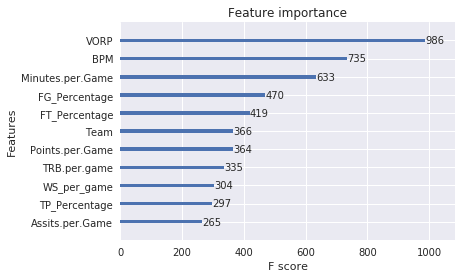

In [14]:
# Let's take a look at the feature importances
from xgboost import plot_importance

plot_importance(model)

In [68]:
xtestencoded = encoder.transform(xtest[feats])

ypred = model.predict(xtestencoded)
ypred
# rmse(ytest, ypred)
# model.score(xtestencoded, ytest)

array([ 5.465291  ,  2.4781559 , 15.744576  ,  2.0652537 , 12.1461525 ,
        3.3892725 ,  1.9435036 ,  1.3358561 ,  7.0275025 ,  2.0476866 ,
       11.33313   , 14.382349  ,  2.2471175 , 12.036127  ,  5.3591895 ,
        4.2045364 ,  9.792991  ,  8.667608  ,  3.9405193 ,  7.932312  ,
       11.118358  , 11.155075  ,  2.6213758 ,  9.204727  ,  1.2954397 ,
        9.43922   ,  0.9181287 ,  7.918626  ,  3.8295329 , 12.0156555 ,
        3.2742372 ,  1.6970787 ,  0.6239192 ,  1.0698272 ,  4.6985793 ,
        9.774577  ,  1.1697717 ,  1.6023242 ,  9.052828  ,  1.5920635 ,
        9.957655  , 12.380114  , 10.973212  ,  2.0676694 ,  2.3023775 ,
        3.633235  , 10.539029  ,  2.3193293 ,  2.0295284 ,  0.5789622 ,
        9.909368  ,  1.6673049 ,  8.109078  ,  0.77847564, 17.264183  ,
        0.992875  , 12.158805  ,  3.2161255 ,  6.8291497 , 13.14031   ,
        0.67942685, 12.351768  , 17.84922   , 13.214468  ,  2.6117458 ,
       11.974856  ,  7.6809697 ,  7.1901126 ,  2.5431159 , 16.10

In [59]:
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000), 
    'xgbregressor__max_depth': randint(3, 9)
}    

# groups = train['tube_assembly_id']
    
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(xtrain, ytrain);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   18.8s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   19.0s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.9s finished


[02:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [60]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 732}
Cross-validation RMSLE 1.9803791835816542


In [37]:
teams = Teams()
teamnames = []
teamabbs = []
for team in teams:
    teamnames.append(team.name)
    teamabbs.append(team.abbreviation)
#     df = pd.DataFrame[np.array([team.name, team.abbreviation])]

nbateams= [teamnames, teamabbs]
nbateams

[['Atlanta Hawks',
  'Milwaukee Bucks',
  'Minnesota Timberwolves',
  'New Orleans Pelicans',
  'New York Knicks',
  'Oklahoma City Thunder',
  'Orlando Magic',
  'Philadelphia 76ers',
  'Phoenix Suns',
  'Portland Trail Blazers',
  'Sacramento Kings',
  'San Antonio Spurs',
  'Toronto Raptors',
  'Utah Jazz',
  'Miami Heat',
  'Memphis Grizzlies',
  'Boston Celtics',
  'Brooklyn Nets',
  'Chicago Bulls',
  'Charlotte Hornets',
  'Cleveland Cavaliers',
  'Dallas Mavericks',
  'Denver Nuggets',
  'Detroit Pistons',
  'Golden State Warriors',
  'Houston Rockets',
  'Indiana Pacers',
  'Los Angeles Clippers',
  'Los Angeles Lakers',
  'Washington Wizards'],
 ['ATL',
  'MIL',
  'MIN',
  'NOP',
  'NYK',
  'OKC',
  'ORL',
  'PHI',
  'PHO',
  'POR',
  'SAC',
  'SAS',
  'TOR',
  'UTA',
  'MIA',
  'MEM',
  'BOS',
  'BRK',
  'CHI',
  'CHO',
  'CLE',
  'DAL',
  'DEN',
  'DET',
  'GSW',
  'HOU',
  'IND',
  'LAC',
  'LAL',
  'WAS']]

In [49]:
# Now, let's bring in sportsreference to start grabbing the rosters
clips = Roster('LAC', slim=True)
clipssquad = clips.players
# for baller in clips.players:
#     print(baller.player_id)
clipssquad


<bound method Roster._get_id of <sportsreference.nba.roster.Roster object at 0x7f8032d5b5c0>>

In [47]:
clipsID = list(clipssquad.keys())
clipsNames = list(clipssquad.values())
clipsID, clipsNames

(['harklma01',
  'willilo02',
  'shamela01',
  'robinje01',
  'georgpa01',
  'harremo01',
  'kabenmf01',
  'mannte01',
  'leonaka01',
  'zubaciv01',
  'mcgruro01',
  'beverpa01',
  'greenja01',
  'motlejo01',
  'coffeam01',
  'waltode01',
  'pattepa01'],
 ['Maurice Harkless',
  'Lou Williams',
  'Landry Shamet',
  'Jerome Robinson',
  'Paul George',
  'Montrezl Harrell',
  'Mfiondu Kabengele',
  'Terance Mann',
  'Kawhi Leonard',
  'Ivica Zubac',
  'Rodney McGruder',
  'Patrick Beverley',
  'JaMychal Green',
  'Johnathan Motley',
  'Amir Coffey',
  'Derrick Walton',
  'Patrick Patterson'])

In [57]:
Player('leonaka01').dataframe

,and_ones,assist_percentage,assists,block_percentage,blocking_fouls,blocks,box_plus_minus,center_percentage,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,dunks,effective_field_goal_percentage,field_goal_attempts,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,field_goal_perc_three_to_ten_feet,field_goal_perc_zero_to_three_feet,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,games_played,games_started,half_court_heaves,half_court_heaves_made,height,lost_ball_turnovers,minutes_played,nationality,net_plus_minus,offensive_box_plus_minus,offensive_fouls,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,on_court_plus_minus,other_turnovers,passing_turnovers,percentage_field_goals_as_dunks,percentage_of_three_pointers_from_corner,percentage_shots_three_pointers,percentage_shots_two_pointers,percentage_sixteen_foot_plus_two_pointers,percentage_ten_to_sixteen_footers,percentage_three_to_ten_footers,percentage_zero_to_three_footers,personal_fouls,player_efficiency_rating,player_id,point_guard_percentage,points,points_generated_by_assists,position,power_forward_percentage,salary,shooting_distance,shooting_fouls,shooting_fouls_drawn,shooting_guard_percentage,shots_blocked,small_forward_percentage,steal_percentage,steals,take_fouls,team_abbreviation,three_point_attempt_rate,three_point_attempts,three_point_percentage,three_point_shot_percentage_from_corner,three_pointers,three_pointers_assisted_percentage,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,two_point_attempts,two_point_percentage,two_pointers,two_pointers_assisted_percentage,usage_percentage,value_over_replacement_player,weight,win_shares,win_shares_per_48_minutes
2011-12,None,6.6,70,1.1,None,24,4.3,0,2.3,16.4,223,2.4,29,0.543,404,0.368,0.324,0.394,0.698,0.493,199,0.218,88,0.773,68,64,39,0,0,6-7,None,1534,United States of America,None,2.0,None,7.9,104,3.1,None,None,None,0.082,0.450,0.270,0.730,0.094,0.092,0.176,0.369,88,16.6,leonaka01,0,507,None,SF,0,1731960,11.1,None,None,0,None,0,2.9,85,None,SAS,0.270,109,0.376,0.469,41,0.976,12.2,327,0.573,9.0,44,295,0.536,158,0.532,14.5,2.4,230,5.5,0.171
2012-13,None,7.7,93,1.3,None,32,3.9,0,2.5,17.1,283,3.3,47,0.556,526,0.424,0.510,0.438,0.659,0.494,260,0.240,126,0.825,104,58,57,0,0,6-7,None,1810,United States of America,None,1.4,None,4.3,63,3.0,None,None,None,0.105,0.695,0.331,0.669,0.125,0.093,0.122,0.329,99,16.4,leonaka01,0,689,None,SF,0,1861920,12.7,None,None,0,None,0,2.7,97,None,SAS,0.331,174,0.374,0.430,65,0.985,11.1,346,0.592,9.6,62,352,0.554,195,0.544,16.4,2.7,230,6.2,0.166
2013-14,None,10.4,133,1.9,None,50,5.8,0,3.4,18.9,336,3.9,59,0.576,645,0.505,0.468,0.505,0.694,0.522,337,0.195,126,0.802,101,66,65,0,0,6-7,None,1923,United States of America,None,2.3,None,4.6,76,3.8,None,None,None,0.098,0.429,0.282,0.718,0.147,0.119,0.147,0.304,127,19.4,leonaka01,0,844,None,SF,0,1887840,12.5,None,None,0,None,0,3.0,114,None,SAS,0.282,182,0.379,0.372,69,0.884,12.1,412,0.602,10.3,80,463,0.579,268,0.519,18.3,3.8,230,7.7,0.193
2014-15,None,13.0,161,1.8,None,48,6.1,0,3.5,20.6,376,4.4,49,0.520,822,0.416,0.481,0.426,0.724,0.479,394,0.307,252,0.802,202,64,64,0,0,6-7,None,2033,United States of America,None,2.6,None,4.8,85,4.2,None,None,None,0.066,0.385,0.234,0.766,0.187,0.187,0.180,0.212,128,22.0,leonaka01,0,1057,None,SF,0,2894059,13.1,None,None,0,None,0,3.7,148,None,SAS,0.234,192,0.349,0.459,67,0.970,12.9,461,0.567,9.4,97,630,0.519,327,0.450,23.0,4.1,230,8.6,0.204
2015-16,None,13.0,186,2.3,None,71,8.3,0,2.8,18.4,398,5.5,64,0.565,1090,0.376,0.498,0.472,0.730,0.506,551,0.306,334,0.874,292,72,72,0,0,6-7,None,2380,United States of America,None,5.5,None,4.7,95,8.3,None,None,None,0.061,0.220,0.267,0.733,0.178,0.201,0.148,0.207,133,26.0,leonaka01,0,1523,None,SF,0,16500000,13.3,None,None,0,None,0,2.8,128,None,SAS,0.267,291,0.443,0.484,129,0.860,11.8,493,0

In [69]:
Player('leonaka01').name

TypeError: 'Player' object is not iterable

In [54]:
for ID in clipsID:
    pd.concat(Player(ID).dataframe.iloc(1))

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [48]:
from sportsreference.nba.roster import Player

for ID in clipsID:
    print(Player(ID))

In [49]:
help(Player)

Help on class Player in module sportsreference.nba.roster:

class Player(sportsreference.nba.player.AbstractPlayer)
 |  Get player information and stats for all seasons.
 |  
 |  Given a player ID, such as 'hardeja01' for James Harden, capture all
 |  relevant stats and information like name, nationality, height/weight,
 |  career three-pointers, last season's offensive rebounds, salary, contract
 |  amount, and much more.
 |  
 |  By default, the class instance will return the player's career stats, but
 |  single-season stats can be found by calling the instance with the requested
 |  season as denoted on basketball-reference.com.
 |  
 |  Parameters
 |  ----------
 |  player_id : string
 |      A player's ID according to basketball-reference.com, such as
 |      'hardeja01' for James Harden. The player ID can be found by navigating
 |      to the player's stats page and getting the string between the final
 |      slash and the '.html' in the URL. In general, the ID is in the format